In [ ]:
import zipfile
with zipfile.ZipFile('../datasets/audio_yes_no.zip', 'r') as zip_ref:
    zip_ref.extractall('../datasets')

In [1]:
#!pip install librosa

In [1]:
import librosa
librosa.__version__

'0.10.0.post2'

In [2]:
import matplotlib
matplotlib.__version__

'3.7.1'

In [3]:
%matplotlib inline

# Audio

## Task 1

Для начала познакомимся с этими записями. \
Установи библиотеку [librosa](https://librosa.org/). Это популярная библиотека для работы с аудио.
Визуализируй аудио сигнал файла `0_1_0_1_1_1_0_0.wav` с помощью функции [librosa.display.waveshow](https://librosa.org/doc/main/generated/librosa.display.waveshow.html)
График должен быть такой же, как показано ниже (по значениям):

![waveform](../misc/images/waveform.png)
>Для того, чтобы прослушать это аудио файл, можешь воспользоваться [IPython.display.Audio](http://ipython.org/ipython-doc/stable/api/generated/IPython.display.html#IPython.display.Audio)

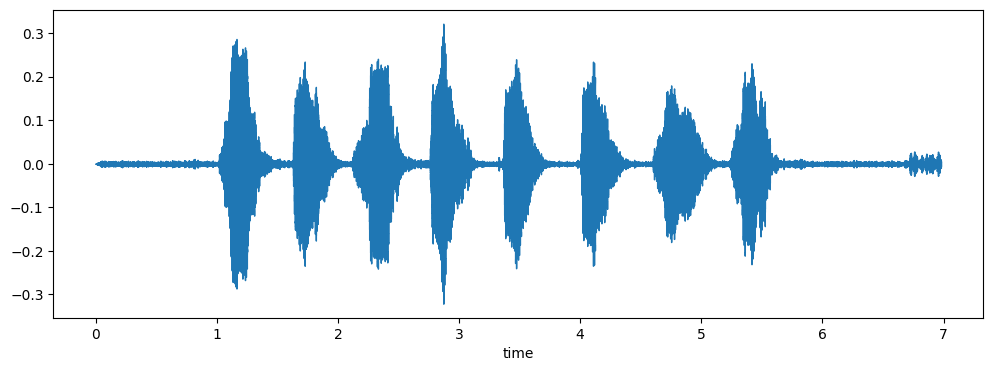

In [4]:
import librosa.display
import matplotlib.pyplot as plt

# загрузка аудиофайла
audio_path = '../datasets/waves_yesno 2/0_1_0_1_1_1_0_0.wav'
waveform, sr = librosa.load(audio_path)

# отображение аудио сигнала
plt.figure(figsize=(12, 4))
librosa.display.waveshow(waveform, sr=sr)
plt.xlabel('time')
plt.show()

In [6]:
import IPython.display as ipd

# воспроизведение аудиофайла
ipd.Audio(audio_path)

## Task 2

Для классификации обычно использует не просто аудио сигнал, а его частотно-временное представление. Для этого сигнал требуется
преобразовать с помощью [оконного преобразования Фурье](https://clck.ru/34JnZD).
С помощью функции [librosa.display.specshow](https://librosa.org/doc/main/generated/librosa.display.specshow.html) 
выведи спектрограмму сигнала. \
График должен быть такой же, как показано ниже (по значениям):
![sftp](../misc/images/sftp.png)

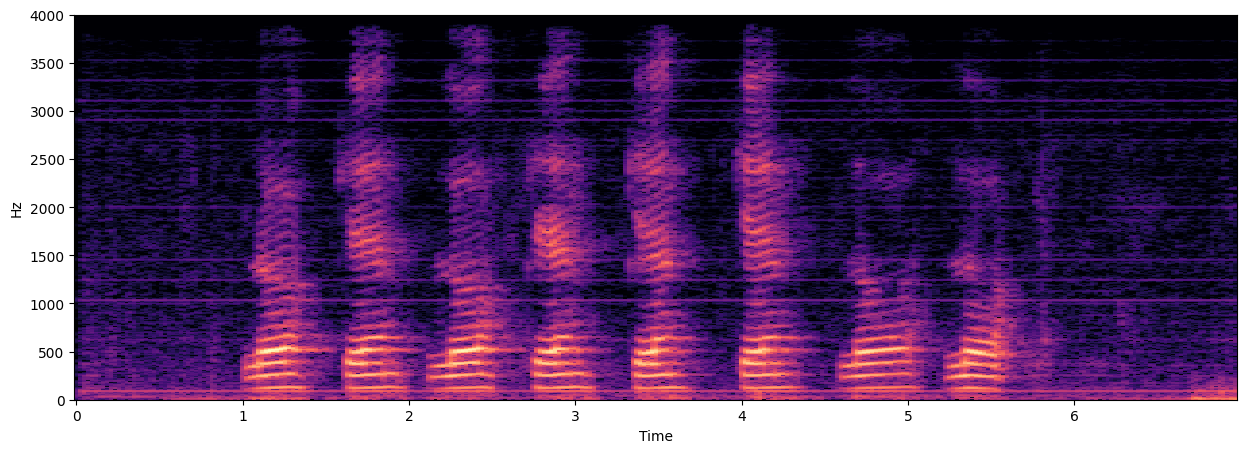

In [5]:
# вычисление спектрограммы
stft = librosa.stft(waveform)
spectrogram = librosa.amplitude_to_db(abs(stft))

# визуализация спектрограммы с обрезанным окном по оси y до 4000 Гц
plt.figure(figsize=(15, 5))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear')
plt.ylim(0, 4000)
plt.show()

## Task 3

C помощью функции [load_dataset](code-samples/audio_utils.py) загрузи датасет. \
Раздели его на train и test c параметрами `test_size=0.2`, `random_state=42`. \
Выведи количество файлов в train и test частях.

def load_dataset(directory: str):
    sr = None
    X, labels, files = [], [], []
    for f in glob(directory + "/*.wav"):
        filename = os.path.basename(f)
        name = filename[:-4]
        y = [int(label) for label in name.split("_")]
        x, sr = librosa.load(f)
        X.append(x)
        labels.append(y)
        files.append(filename)

    return X, labels, sr, files

In [6]:
from sklearn.model_selection import train_test_split
import os

# путь к директории с кодом и датасетом
code_directory = '../code-samples'
dataset_directory = '../datasets/waves_yesno 2'

# загрузка функции load_dataset из файла audio_utils.py
import sys
sys.path.append(os.path.abspath(code_directory))
from audio_utils import *

# загрузка датасета
X, labels, sr, files = load_dataset(dataset_directory)

# разделение на обучающую и тестовую выборки
X_train, X_test, labels_train, labels_test, files_train, files_test = train_test_split(
    X, labels, files, test_size=0.2, random_state=42)

print("Количество файлов в train (обучающей выборке):", len(X_train), ", в test (тестовой выборке):", len(X_test))

Количество файлов в train (обучающей выборке): 47 , в test (тестовой выборке): 12


## Task 4

Наши аудио записи содержат как речь человека, так и молчание. Для каждой записи нам нужно определить сегменты записи, 
где человек молчит, а где произносит слова. \
Эта задача называется [Voice Activity Detection (VAD)](https://ru.wikipedia.org/wiki/Voice_Activity_Detection).
Придумайте или найдите метод, по которому можно распознавать участки с речью на аудио записи.

Например:
Запись '0_0_0_1_0_1_1_0.wav' содержит 137592 отсчетов. Сегменты с речью для этой записи (Отмечены красным):
[[23996, 32539],
 [35410, 44925],
 [49493, 57410],
 [60458, 68635],
 [73308, 81278],
 [84001, 91942],
 [97381, 104166],
 [109018, 115573]] 
![sftp](../misc/images/vad.png)

Выведи несколько примеров работы твоего VAD-алгоритма, по аналогии с примером, для других аудио записей. Попробуй добиться
наилучшего качества нахождения речи.

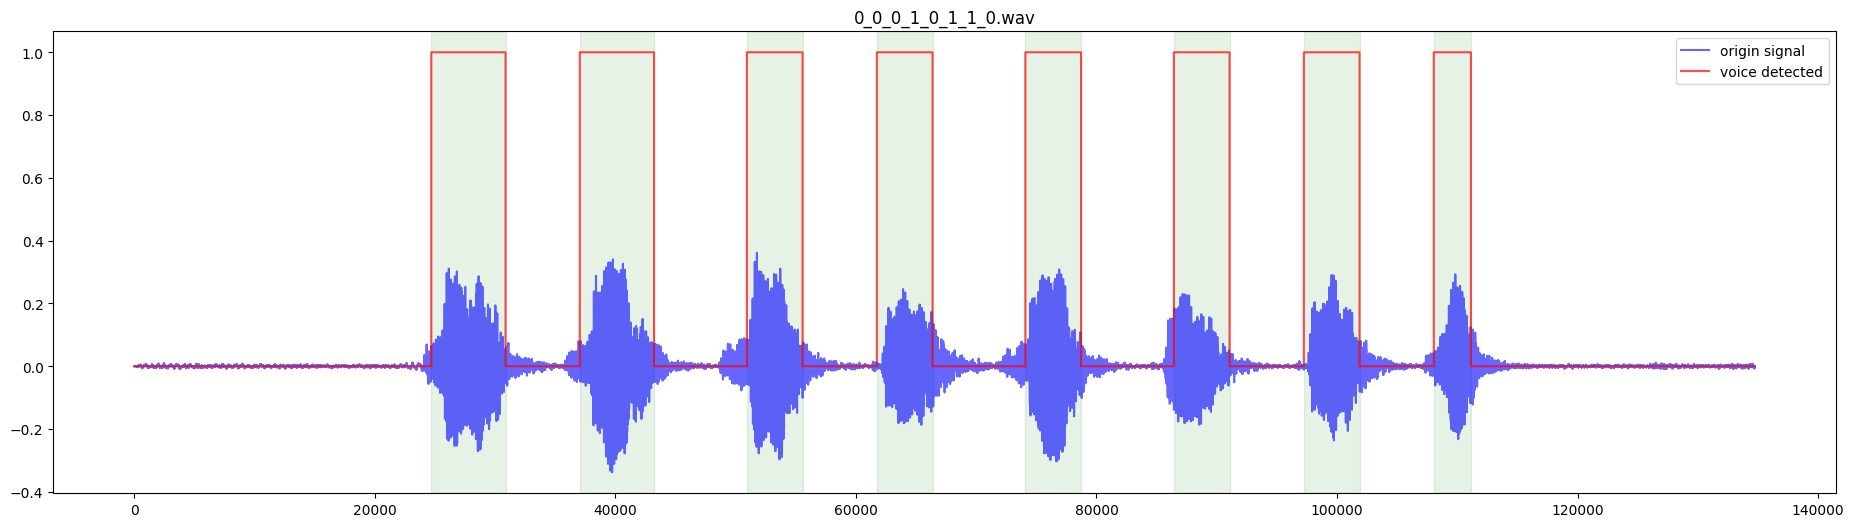

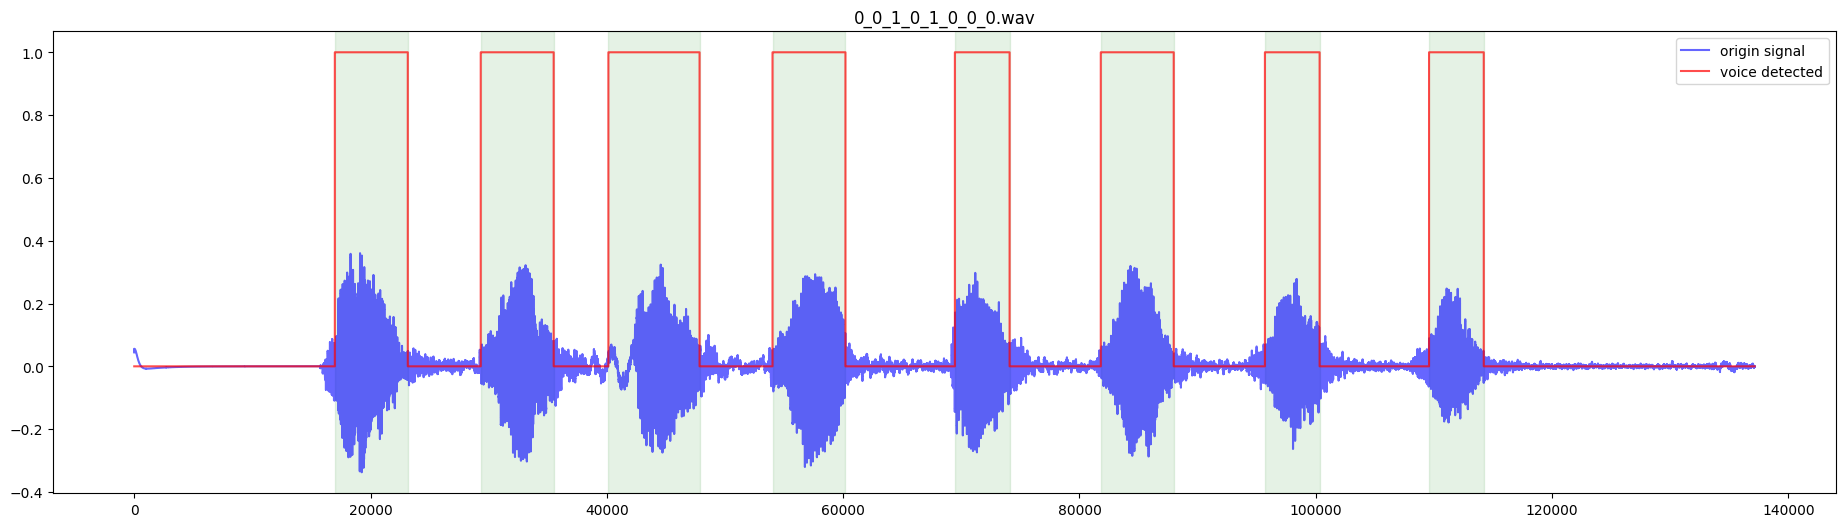

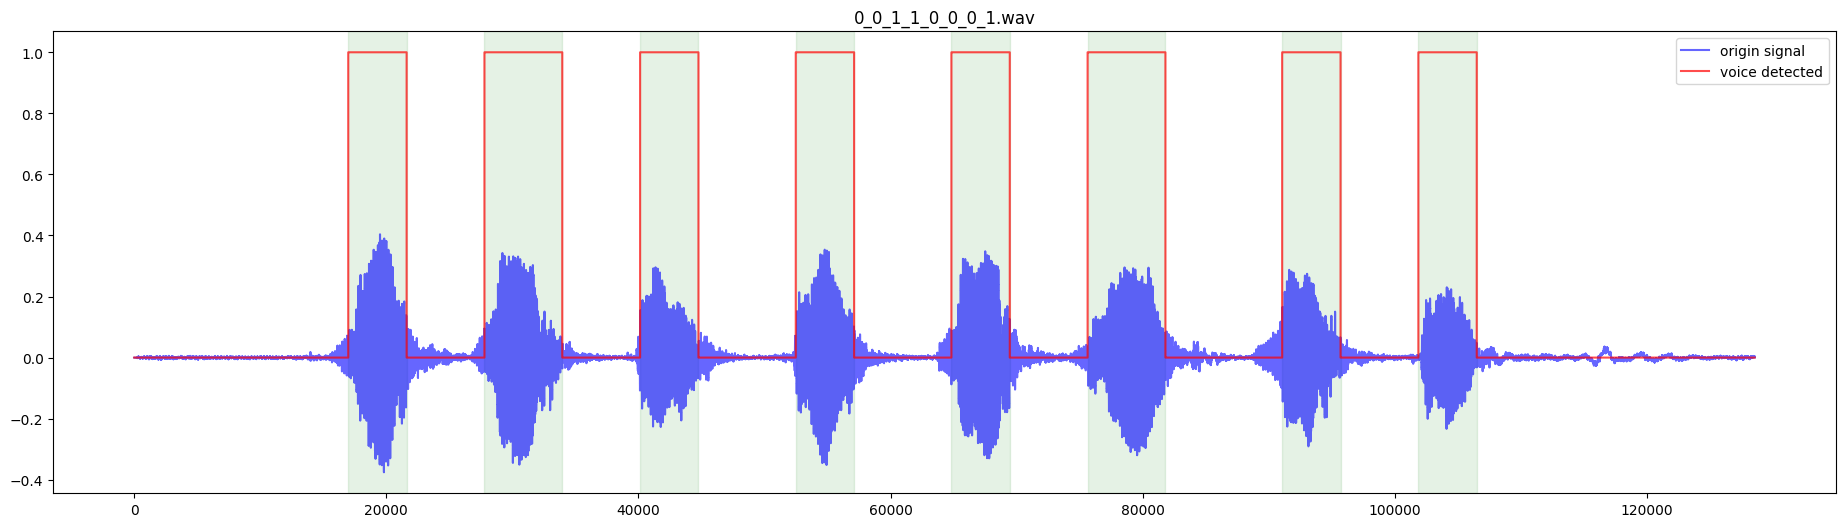

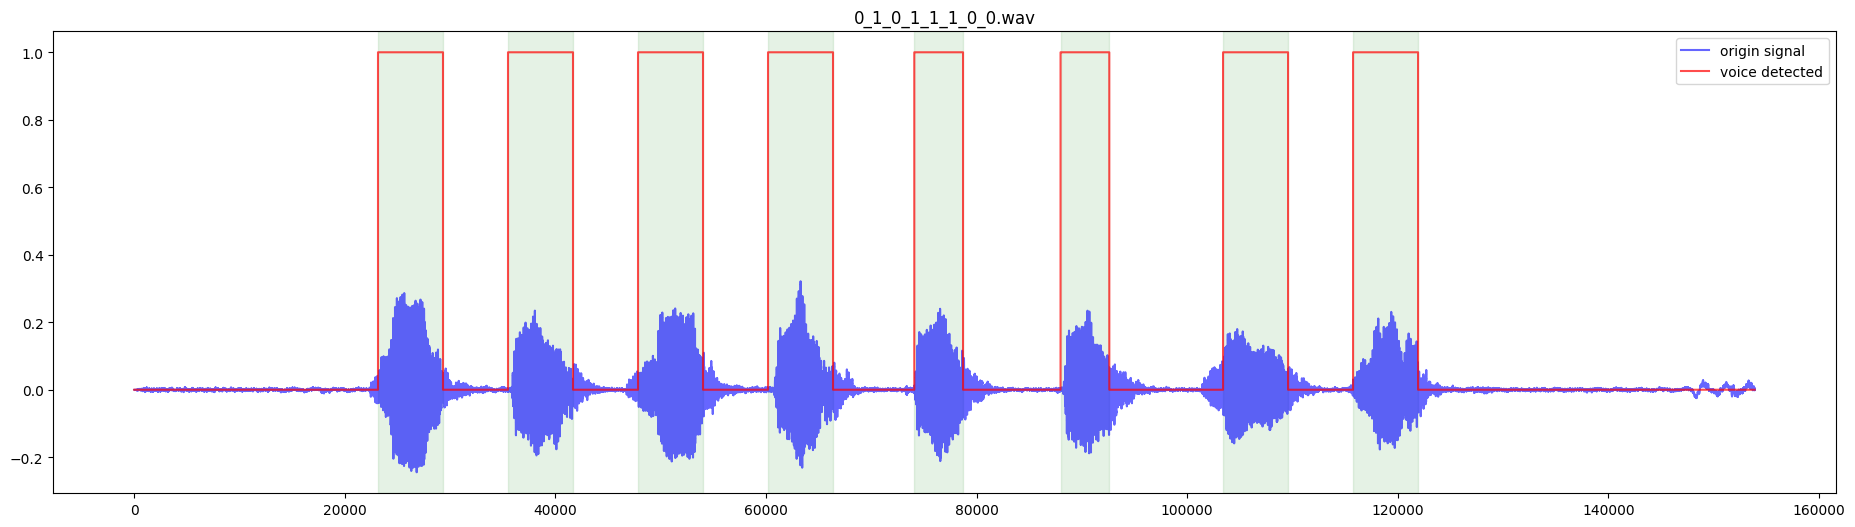

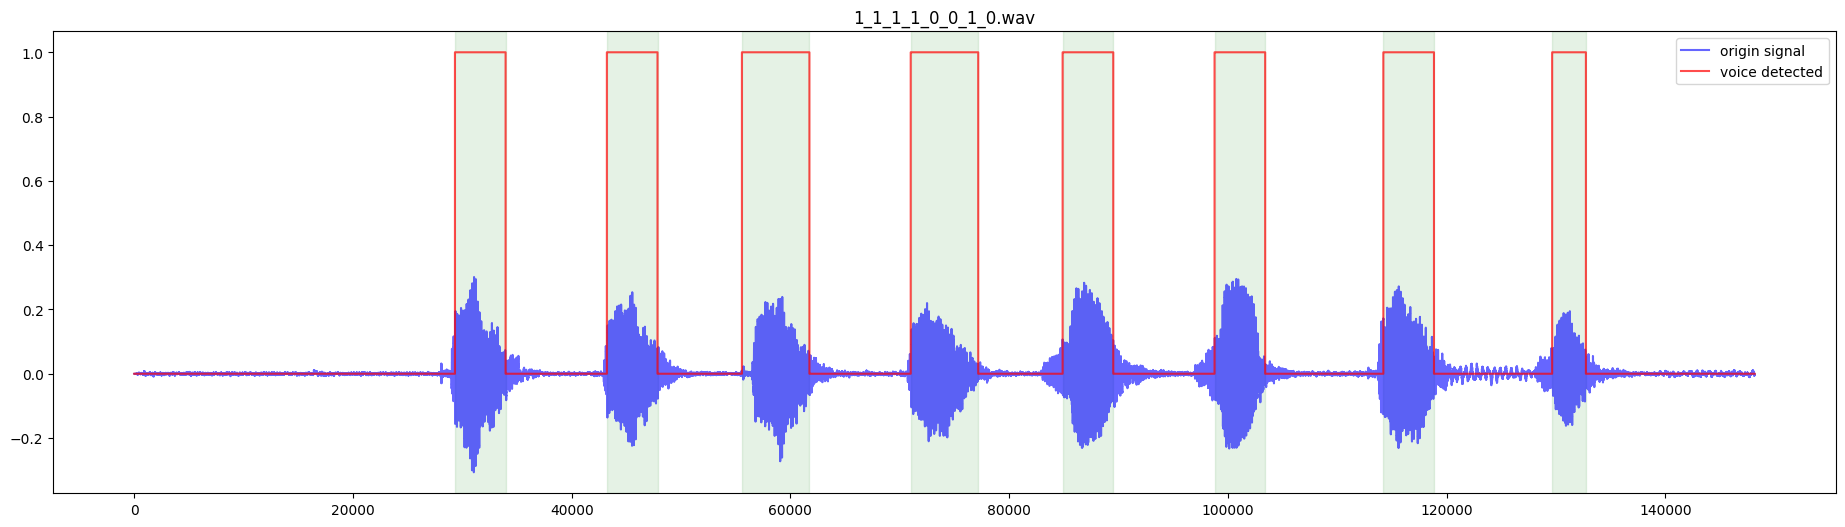

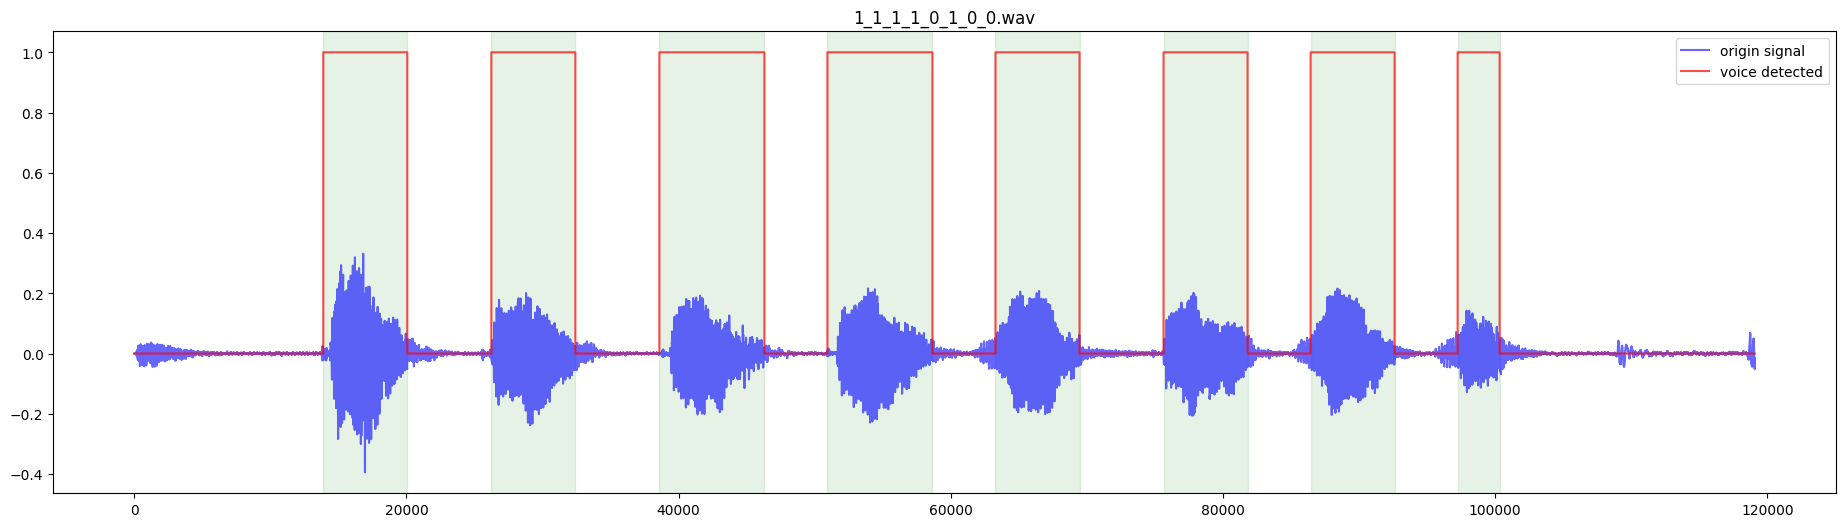

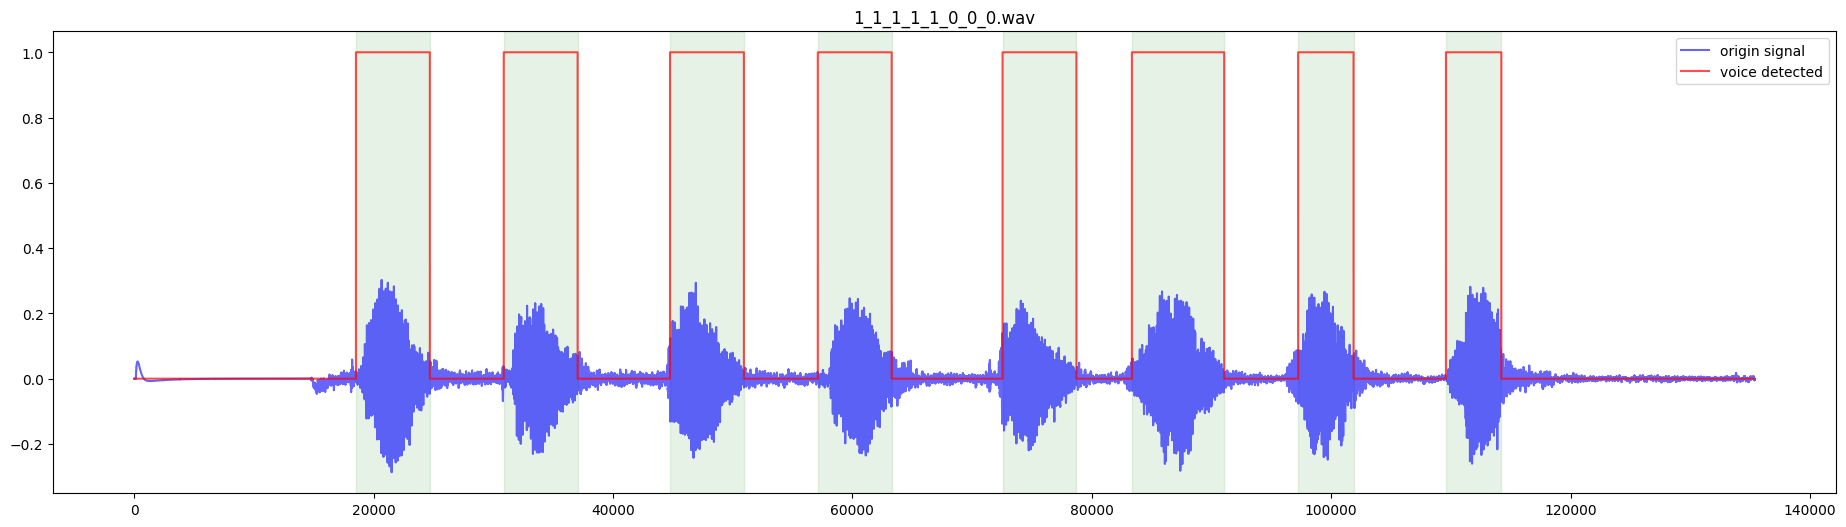

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# некоторый файлы для анализа
files_ok = ['0_0_0_1_0_1_1_0.wav', '0_0_1_0_1_0_0_0.wav', '0_0_1_1_0_0_0_1.wav', '0_1_0_1_1_1_0_0.wav',
            '1_1_1_1_0_0_1_0.wav', '1_1_1_1_0_1_0_0.wav', '1_1_1_1_1_0_0_0.wav']

# получение списка файлов с расширением .wav
files = [f for f in os.listdir(dataset_directory) if f.endswith('.wav')]

# параметры VAD (Voice Activity Detection)
frame_duration = 0.07  # длительность фрейма в секундах
energy_threshold = 0.06  # пороговое значение энергии

vad_segments = []
for file in files:
    audio_path = os.path.join(dataset_directory, file)

    # загрузка аудиофайла
    audio, sample_rate = librosa.load(audio_path)

    # вычисление энергии фреймов
    frame_size = int(frame_duration * sample_rate)
    num_frames = len(audio) // frame_size

    frame_energy = np.zeros(num_frames)  # массив для хранения энергии фреймов
    for j in range(num_frames):
        frame_start = j * frame_size
        frame_end = frame_start + frame_size
        frame = audio[frame_start:frame_end]
        frame_energy[j] = np.sum(np.square(frame))  # вычисление энергии фрейма

    # определение порогового значения энергии
    threshold = energy_threshold * np.max(frame_energy)

    # определение сегментов речи
    is_speech = frame_energy > threshold
    speech_segments = []  # список сегментов речи
    start_time = 0

    for k in range(1, num_frames):
        if is_speech[k] and not is_speech[k-1]:
            start_point = int(k * frame_duration * sample_rate)  # начало сегмента речи
        elif not is_speech[k] and is_speech[k-1]:
            end_point = int(k * frame_duration * sample_rate)  # конец сегмента речи
            speech_segments.append([start_point, end_point])  # добавление сегмента речи в список
    vad_segments.append(speech_segments)
    if file not in files_ok:
        continue
    
    # визуализация аудиосигнала и сегментов речи
    plt.figure(figsize=(23, 6))
    plt.title(file)

    # линия, обозначающая сегменты речи
    speech_line = np.zeros(len(audio))
    for segment in speech_segments:
        plt.axvspan(segment[0], segment[1], color='green', alpha=0.1)
        speech_line[segment[0]:segment[1]] = 1

    # отображение аудиосигнала и сегментов речи
    plt.step(np.arange(len(audio)), audio, color='blue', label='origin signal', alpha=0.6)
    plt.step(np.arange(len(audio)), speech_line, color='red', label='voice detected', alpha=0.7)

    plt.legend()
    plt.show()

## Task 5

После того как мы узнали сегменты аудио с речью, то можно перейти к самой задаче классификации. \
Внимательно изучи функцию [make_dataset](code-samples/audio_utils.py). С помощью этой функции cгенерируй X, Y для train и test выборок.
Затем попробуй обучить различные классификаторы. Например, SVM или LogisticRegression.
Измерь точность (accuracy) классификации на тестовой выборке.

def make_dataset(samples, labels, vad_segments):
    """

    :param samples: Список аудио сигналов
    :param labels: Список меток (Например для файла '0_0_0_1_0_1_1_0.wav': [0, 0, 0, 1, 0, 1, 1, 0])
    :param vad_segments: Список сегментов для каждого аудио сигнала вида:
        [
            [[23996, 32539], [35410, 44925], ...,],
            [[22141, 30259], [34917, 42695], ...,],
            ...
        ]
    :return:
    """
    X, y = [], []
    # Проходим по каждому аудио сигналу
    for sample in range(len(samples)):
        # В аудио сигнале проходим по каждому сегменту с речью
        for segment in range(len(vad_segments[sample]) - 1):
            start = vad_segments[sample][segment][0]  # Начало сегмента
            stop = vad_segments[sample][segment][1]  # Конец сегмента
            voice = samples[sample][start:stop]  # Отрезаем сегмент с речью из аудио сигнала и применяем stft
            stft = librosa.stft(voice).mean(axis=1)
            stft_db = librosa.amplitude_to_db(abs(stft))

            X.append(stft_db)  # Добавляем спектрограмму с речью
            y.append(labels[sample][segment])  # Добавляем метку для этой спектрограммы

    return np.array(X), np.array(y)

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X2, y = make_dataset(X, labels, vad_segments)

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

# инициализация и обучение классификатора SVM
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# предсказание меток для тестовой выборки с использованием SVM
svm_predictions = svm_classifier.predict(X_test)

# оценка точности классификации для SVM
svm_accuracy = accuracy_score(y_test, svm_predictions)

# инициализация и обучение классификатора Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# предсказание меток для тестовой выборки с использованием Logistic Regression
lr_predictions = lr_classifier.predict(X_test)

# оценка точности классификации для Logistic Regression
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("точность (accuracy) классификации на тестовой выборке:")
print("  для SVM:", svm_accuracy)
print("  для Logistic Regression:", lr_accuracy)

точность (accuracy) классификации на тестовой выборке:
  для SVM: 1.0
  для Logistic Regression: 1.0
